<a href="https://colab.research.google.com/github/AndrewJGroves/PlottingInformation/blob/main/NuclearMissle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plotting Nuclear Missle Data

Code to take data on nuclear missiles by country and plot them on a graph

In [78]:
pip install wikipedia

Start my taking the information from wikipedia and cleaning it

In [79]:
import pandas as pd
import wikipedia as wp
import numpy as np

html = wp.page("Historical nuclear weapons stockpiles and nuclear tests by country").html().encode("UTF-8")
df = pd.read_html(html)[0] 

#Finding the countires and putting them into the index of a new data frame
countries=list(df.columns[0]) 
countries=countries[1:-1]
new_df=pd.DataFrame(columns=countries)

for i in range(1,len(df.columns)-1):
  li=list(df.columns[i])
  year=li[0]
  li=li[1:-1]
  new_li=[]
  for i in li: #Cleaning the data and making the numbers useable
    if i == 'â\x80\x94':
      new_li.append(0)
    else:
      x=i.split('-')
      if len(x) > 1:
        x=x[1]
      else:
        x=x[0]
      x=x.split('[',1)
      x=x[0]
      x=x.split()
      x=x[0]
      x=x.replace(',','')
      try:
        x=int(x)
      except:
        x=np.nan
      new_li.append(x)
  new_df.loc[year]=new_li
new_df.fillna(81,inplace=True) #Single value was hard to deal with and fast to input by hand due to the size of the dataframe

df = new_df.rename(columns = {'United States': 'US', 'Soviet Union Russia': 'USSR/Russia','United Kingdom':'UK'}, inplace = False)
df.index = pd.to_datetime(df.index)
df.index.name = 'date'
df=df.replace([0],np.nan)
del df['South Africa']
del df['Kazakhstan']
del df['Ukraine']
del df['Belarus']
del df['Lithuania']

df.head(20)


,US,USSR/Russia,China,France,UK,India,Pakistan,Israel,North Korea
date,,,,,,,,,
1945-01-01,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-01,299.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-01-01,2422.0,200.0,NaN,NaN,14.0,NaN,NaN,NaN,NaN
1960-01-01,18638.0,1605.0,NaN,NaN,42.0,NaN,NaN,NaN,NaN
1965-01-01,31149.0,6129.0,5.0,32.0,436.0,NaN,NaN,NaN,NaN
1970-01-01,26008.0,11643.0,75.0,36.0,394.0,NaN,NaN,8.0,NaN
1975-01-01,27519.0,19055.0,180.0,188.0,492.0,NaN,NaN,20.0,NaN
1980-01-01,23368.0,30062.0,205.0,250.0,492.0,1.0,NaN,31.0,NaN
1985-01-01,21392.0,39197.0,243.0,360.0,422.0,3.0,NaN,42.0,NaN


Now we have a dataframe to work with we can start to do plotting, first I will do it with matplotlib before trying with seaborn

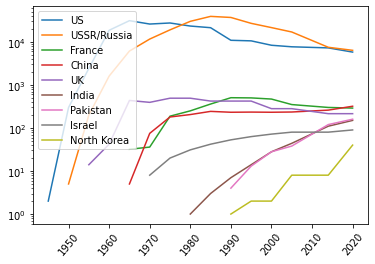

In [80]:
from matplotlib import pyplot as plt

plt.figure()
ax=plt.subplot()
plt.plot(df.index, df['US'],label='US')
plt.plot(df.index, df['USSR/Russia'],label='USSR/Russia')
plt.plot(df.index, df['France'],label='France')
plt.plot(df.index, df['China'],label='China')
plt.plot(df.index, df['UK'],label='UK')
plt.plot(df.index, df['India'],label='India')
plt.plot(df.index, df['Pakistan'],label='Pakistan')
plt.plot(df.index, df['Israel'],label='Israel')
plt.plot(df.index, df['North Korea'],label='North Korea')
ax.set_yscale('log')
plt.xticks(rotation=50)
plt.legend()
plt.show()

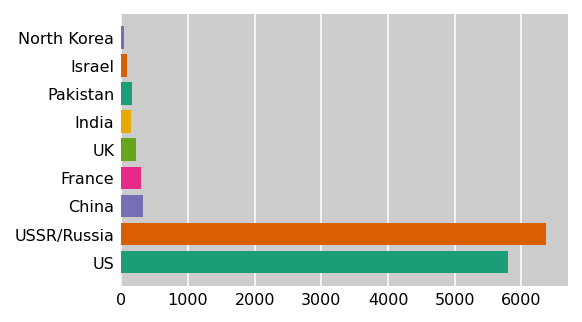

In [81]:
def nice_axes(ax):
    ax.set_facecolor('.8')
    ax.tick_params(labelsize=8, length=0)
    ax.grid(True, axis='x', color='white')
    ax.set_axisbelow(True)
    [spine.set_visible(False) for spine in ax.spines.values()]

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=144)
colors = plt.cm.Dark2(range(6))
s = df.loc['2020-01-01']
y = s.index
width = s.values
ax.barh(y=y, width=width, color=colors);    
nice_axes(ax)


In [82]:
def prepare_data(df, steps=5):
    df = df.reset_index()
    df.index = df.index * steps
    last_idx = df.index[-1] + 1
    df_expanded = df.reindex(range(last_idx))
    df_expanded['date'] = df_expanded['date'].fillna(method='ffill')
    df_expanded = df_expanded.set_index('date')
    df_rank_expanded = df_expanded.rank(axis=1, method='first')
    df_expanded = df_expanded.interpolate()
    df_rank_expanded = df_rank_expanded.interpolate()
    return df_expanded, df_rank_expanded

df_expanded, df_rank_expanded = prepare_data(df)
df_expanded.head()
labels = df_expanded.columns


In [83]:
from matplotlib.animation import FuncAnimation

def init():
    ax.clear()
    nice_axes(ax)
    ax.set_ylim(.2, 6.8)

def update(i):
    for bar in ax.containers:
        bar.remove()
    y = df_rank_expanded.iloc[i]
    width = df_expanded.iloc[i]
    ax.barh(y=y, width=width, color=colors, tick_label=labels)
    date_str = df_expanded.index[i].strftime('%B %-d, %Y')
    ax.set_title(f'Nuclear Warheads by Country - {date_str}', fontsize='smaller')
    
fig = plt.Figure(figsize=(4, 2.5), dpi=144)
ax = fig.add_subplot()
anim = FuncAnimation(fig=fig, func=update, init_func=init, frames=len(df_expanded), 
                     interval=100, repeat=False)

In [84]:
from IPython.display import HTML
html = anim.to_html5_video()
HTML(html)
anim.save('Nuclear.mp4')
